# Tiling Data

This notebook demonstrates how tiling can be applied to a dataset.

# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:


In [ ]:
%pip install anomalib

## Setting up the Dataset Directory

This cell is to ensure we change the directory to have access to the datasets.


In [1]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parent / "datasets" / "MVTec" / "transistor"

# Tiling Large Images

In the literature on deep learning, input image sizes typically range from 224 to 768 pixels. In the majority of industrial applications, however, input image sizes are significantly larger. Before the forward pass, these images are resized to a smaller scale before being fed into the models. However, this is problematic in the context of anomaly detection tasks, where the anomaly is typically quite small. The detection of abnormalities becomes extremely difficult when the image is shrunk in size. A common method for addressing this issue is to tile the input images so that no information is lost during the resizing operation.

This notebook demonstrates how tiling works in anomalib, and how tiling can be enabled when training a model using anomalib.


In [2]:
import torch
from torchvision.io import read_image
from torchvision.transforms import Resize, ToPILImage
from torchvision.utils import draw_segmentation_masks, make_grid

from anomalib.data.utils.tiler import Tiler

### Effect of Resizing the Input Image


In [3]:
# Assuming that datasets directory is located in the root directory.
image = read_image(path=str(dataset_root / "test/cut_lead/000.png"))
mask = read_image(path=str(dataset_root / "ground_truth/cut_lead/000_mask.png")).bool()
overlayed_image = draw_segmentation_masks(image, mask, alpha=0.2, colors=["red"])

In [ ]:
ToPILImage()(overlayed_image)

As can be seen above, the original MVTec image is 1024x1024. Most anomaly detection algorithms resize this input size into a smaller value such as 256x256. As mentioned above, this poses a problem for small anomalous regions as they become even smaller. Let's visualize this by resizing the input image into 256x256 image.


In [5]:
resized_image = Resize((256, 256))(image)
resized_mask = Resize((256, 256))(mask)
resized_overlayed_image = draw_segmentation_masks(resized_image, resized_mask, alpha=0.5, colors=["red"])

/home/sakcay/.pyenv/versions/3.10.11/envs/notebooks/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


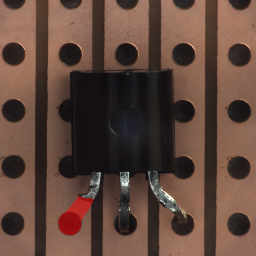

In [6]:
ToPILImage()(resized_overlayed_image)

The figures above demonstrates how resizing affect the input image size. The original image is 1024x1024. The resized image is 256x256. The anomaly is now much smaller and is difficult to detect.

### Effect of Tiling

To avoid losing information with resizing we could instead tile the image into multiple patches. We could utilize anomalib's `Tiler` object to do this. The `Tiler` object takes in the input image and the desired output size. It then tiles the image into patches of the desired size. The `Tiler` object also returns the coordinates of the patches in the original image. This is useful for reconstructing the tiled image back into the original image. Let's create a tiler object, tile the input image and visualize the tiled image.


In [7]:
tiler = Tiler(tile_size=(256, 256), stride=256)

where stride is the parameter defining the spatial distance in pixels between adjacent tiles, and tile size is the size of each tile (patches). Tile size and stride are here defined as (256, 256) and 256, respectively. As a result, we move 256 pixels to the right to take 256x256 patches. This will result in "non-overlapping tiles".


In [8]:
tiled_image = tiler.tile(image).type(torch.uint8)
tiled_mask = tiler.tile(mask).type(torch.bool)

In [9]:
print(tiled_image.shape, tiled_mask.shape)

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])


In [ ]:
ToPILImage()(make_grid(tiled_image, nrow=4, padding=5))

The image is tiled into non-overlapping patches as seen in the figure above. We have 16 patches in total because the original input size is 1024x1024 and the tile and stride sizes are (256, 256) and 25, respectively. As we can see, the fourteenth tile is the one that contains the anomalous region. We can visualize it by running the following:


In [11]:
overlayed_tile = draw_segmentation_masks(tiled_image[13], tiled_mask[13], alpha=0.2, colors=["red"])

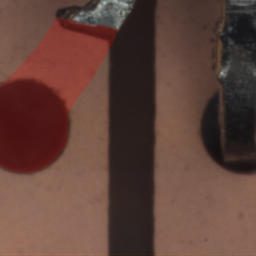

In [12]:
ToPILImage()(overlayed_tile)

We could also visualize the resized image and the tiled region by stacking them together. This would show how tiling could preserve the data that resizing operations would otherwise lose.


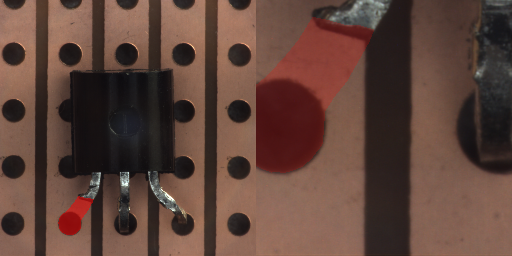

In [13]:
ToPILImage()(torch.cat([resized_overlayed_image, overlayed_tile], dim=2))

Overall, tiling could be a useful feature when the input image size is large and the anomalous region size is small. Tiling the input could avoid information loss that would otherwise occur with resizing.


## Tiling in Anomalib Training

This section demonstrates how tiling could be enabled in anomalib training. The dataset section in the configuration files needs to be changed in order to enable tiling in anomalib. The dataset contains a tiling section where tiling parameters are set. Below is an illustration of a tiling configuration;

```yaml
tiling:
  apply: false
  tile_size: null
  stride: null
  remove_border_count: 0
  use_random_tiling: False
  random_tile_count: 16
```

For example, to train a dataset with tiling based on 256x256 non-overlapping patches, the following data configuration could be used:

```yaml
tiling:
  apply: true
  tile_size: 256
  stride: 256
  remove_border_count: 0
  use_random_tiling: False
  random_tile_count: 16
```


depending on the use-case ,these tiling configurations could potentially improve the performance of the anomaly detection models.
